In [1]:
import numpy as np

import torch
import torchvision

from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import optim
from torch import nn
from torchvision.utils import save_image

In [2]:
batch_size = 64


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data', 
                   train=True, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ])),batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data', train=False, download=True, transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ])),batch_size=batch_size, shuffle=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# class Encoder(nn.Module):
#     def __init__(self, x_size, h_size, z_size):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(x_size, h_size)
#         self.mu_gen = nn.Linear(h_size, z_size)
#         # make the output to be the logarithm 
#         # i.e will have to take the exponent
#         # which forces variance to be positive
#         # not that this is the diagonal of the covariance
#         self.log_var_gen = nn.Linear(h_size, z_size)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         mu = self.mu_gen(x)
#         log_var = self.log_var_gen(x)
#         return mu, log_var
    
class Encoder(nn.Module):
    r"""
    References:
            [1] Burgess, Christopher P., et al. "Understanding disentangling in
            $\beta$-VAE." arXiv preprint arXiv:1804.03599 (2018).
    """
    def __init__(self, img_size, latent_dim=10):

        super(Encoder, self).__init__()

        hidden_channels = 32
        kernel_size = 4
        hidden_dim = 256

        self.latent_dim = latent_dim
        self.img_size = img_size

        self.reshape = (hidden_channels, kernel_size, kernel_size)

        n_channels = self.img_size[0]

        cnn_kwargs = dict(stride=2, padding=1)

        self.conv1 = nn.Conv2d(n_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.conv3 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)

        if self.img_size[1] == self.img_size[2] == 64:
            self.conv_64 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)

        self.lin1 = nn.Linear(np.product(self.reshape), hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)

        self.mu_logvar_gen = nn.Linear(hidden_dim, self.latent_dim * 2)

    def forward(self, x):
        batch_size = x.size(0)

        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))

        if self.img_size[1] == self.img_size[2] == 64:
            x = torch.relu(self.conv_64(x))

        x = x.view((batch_size, -1))
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.lin2(x))

        mu_logvar = self.mu_logvar_gen(x)

        mu, logvar = mu_logvar.view(-1, self.latent_dim, 2).unbind(-1)

        return mu, logvar

In [5]:
# class Decoder(nn.Module):
#     def __init__(self, x_size, h_size, z_size):
#         super(Decoder, self).__init__()
#         self.fc1 = nn.Linear(z_size, h_size)
#         self.fc3 = nn.Linear(h_size, x_size)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc3(x))
#         # black and white MNIST => sigmoid for each pixel
#         x = torch.sigmoid(x) 
#         return x
    
class Decoder(nn.Module):
    r"""
    References:
            [1] Burgess, Christopher P., et al. "Understanding disentangling in
            $\beta$-VAE." arXiv preprint arXiv:1804.03599 (2018).
    """
    def __init__(self, img_size, latent_dim):

        super(Decoder, self).__init__()

        hidden_channels = 32
        kernel_size = 4
        hidden_dim = 256

        self.img_size = img_size
        self.latent_dim = latent_dim

        self.reshape = (hidden_channels, kernel_size, kernel_size)

        n_channels = self.img_size[0]

        self.lin1 = nn.Linear(latent_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, np.product(self.reshape))

        cnn_kwargs = dict(stride=2, padding=1)

        if self.img_size[1] == self.img_size[2] == 64:
            self.convT_64 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)

        self.convT1 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.convT2 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.convT3 = nn.ConvTranspose2d(hidden_channels, n_channels, kernel_size, **cnn_kwargs)

    def forward(self, z):
        batch_size = z.size(0)

        x = torch.relu(self.lin1(z))
        x = torch.relu(self.lin2(x))
        x = torch.relu(self.lin3(x))

        x = x.view(batch_size, *self.reshape)

        if self.img_size[1] == self.img_size[2] == 64:
            x = torch.relu(self.convT_64(x))

        x = torch.relu(self.convT1(x))
        x = torch.relu(self.convT2(x))

        x = torch.sigmoid(self.convT3(x))

        return x

In [6]:
# class VAE(nn.Module):
#     def __init__(self, x_size, h_size, z_size):
#         super(VAE, self).__init__()
#         self.x_size = x_size
#         self.z_size = z_size
#         self.encoder = Encoder(x_size, h_size, z_size)
#         self.decoder = Decoder(x_size, h_size, z_size)

#     def reparameterize(self, mu, log_var):
#         std = torch.exp(0.5 * log_var) # square root in exponent => std
#         eps = torch.randn_like(std)
#         z = std * eps + mu
#         return z

#     def forward(self, x):
#         # make image linear (i.e vector form)
#         x = x.view(-1, self.x_size)
#         mu, log_var = self.encoder(x)
#         z = self.reparameterize(mu, log_var)
#         x_hat = self.decoder(z)
#         return x_hat, mu, log_var

class VAE(nn.Module):
    def __init__(self, img_size, latent_dim):
        super(VAE, self).__init__()
        if list(img_size[1:]) not in [[32,32], [64,64]]:
            raise RuntimeError("{} sized images not supported. Only (None, 32, 32) and (None, 64, 64) supported. Build your own architecture or reshape images!".format(img_size))

        self.latent_dim = latent_dim
        self.img_size = img_size
        self.num_pixels = self.img_size[1] * self.img_size[2]
        self.encoder = Encoder(img_size, self.latent_dim)
        self.decoder = Decoder(img_size, self.latent_dim)

        self.reset_parameters()

    def reparameterize(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mean + std * eps

        else:
            return mean


    def forward(self, x):
        latent_distribution = self.encoder(x)
        latent_sample = self.reparameterize(*latent_distribution)
        reconstruct = self.decoder(latent_sample)
        return reconstruct, latent_distribution, latent_sample

    def reset_parameters(self):
        self.apply(weights_init)

    def sample_latent(self, x):
        latent_distribution = self.encoder(x)
        latent_sample = self.reparameterize(*latent_distribution)
        return latent_sample

In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

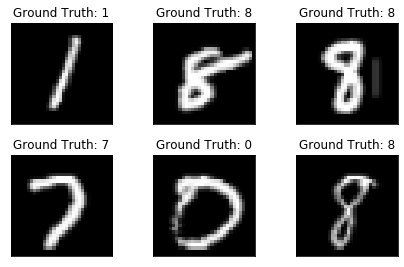

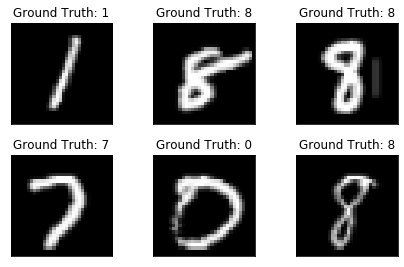

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [9]:
list(example_data[0].shape)

[1, 32, 32]

In [10]:
def get_activation_name(activation):
    """Given a string or a `torch.nn.modules.activation` return the name of the activation."""
    if isinstance(activation, str):
        return activation

    mapper = {nn.LeakyReLU: "leaky_relu", nn.ReLU: "relu", nn.Tanh: "tanh",
              nn.Sigmoid: "sigmoid", nn.Softmax: "sigmoid"}
    for k, v in mapper.items():
        if isinstance(activation, k):
            return k

    raise ValueError("Unkown given activation type : {}".format(activation))


def get_gain(activation):
    """Given an object of `torch.nn.modules.activation` or an activation name
    return the correct gain."""
    if activation is None:
        return 1

    activation_name = get_activation_name(activation)

    param = None if activation_name != "leaky_relu" else activation.negative_slope
    gain = nn.init.calculate_gain(activation_name, param)

    return gain
def linear_init(layer, activation="relu"):
    """Initialize a linear layer.
    Args:
        layer (nn.Linear): parameters to initialize.
        activation (`torch.nn.modules.activation` or str, optional) activation that
            will be used on the `layer`.
    """
    x = layer.weight

    if activation is None:
        return nn.init.xavier_uniform_(x)

    activation_name = get_activation_name(activation)

    if activation_name == "leaky_relu":
        a = 0 if isinstance(activation, str) else activation.negative_slope
        return nn.init.kaiming_uniform_(x, a=a, nonlinearity='leaky_relu')
    elif activation_name == "relu":
        return nn.init.kaiming_uniform_(x, nonlinearity='relu')
    elif activation_name in ["sigmoid", "tanh"]:
        return nn.init.xavier_uniform_(x, gain=get_gain(activation))
def weights_init(module):
    if isinstance(module, nn.modules.conv._ConvNd):
        # TO-DO: check litterature
        linear_init(module)
    elif isinstance(module, nn.Linear):
        linear_init(module)

In [11]:
img_size = list(example_data[0].shape) # mnist image
# h_size = 256
z_size = 12
model = VAE(img_size, z_size).to(device) # migrates to CUDA if you can

In [12]:
model

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lin1): Linear(in_features=512, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
    (mu_logvar_gen): Linear(in_features=256, out_features=24, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=12, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
    (lin3): Linear(in_features=256, out_features=512, bias=True)
    (convT1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [13]:
def linear_annealing(init, fin, step, annealing_steps):
    """Linear annealing of a parameter."""
    if annealing_steps == 0:
        return fin
    assert fin > init
    delta = fin - init
    annealed = min(init + delta * step / annealing_steps, fin)
    return annealed

def _kl_normal_loss(mean, logvar):
    latent_dim = mean.size(1)
    latent_kl = 0.5 * (-1 - logvar + mean.pow(2) + logvar.exp()).mean(dim=0)
    total_kl = latent_kl.sum()

    return total_kl

def _reconstruction_loss(data, recon_data, distribution="bernoulli"):
    batch_size, n_channels, height, width = recon_data.size()
    is_colored = n_channels == 3

    if distribution == "bernoulli":
        loss = F.binary_cross_entropy(recon_data, data, reduction="sum")

    elif distribution == "gaussian":
        loss = F.mse_loss(recon_data * 255, data * 255, reduction="sum") / 255

    elif distribution == "laplace":
        loss = F.l1_loss(recon_data, data, reduction="sum")
        loss = loss * 3
        loss = loss * (loss != 0)

    loss = loss / batch_size

    return loss

def loss_function(x_hat, x, mu, log_var, is_train, n_train_steps, steps_anneal=0, beta=1, C_init=0., C_fin=20., gamma=100.):
    """Compute the ELBO loss"""
    x_size = x_hat.size(-1)
    # black or white image => use sigmoid for each pixel
#     rec_loss = F.binary_cross_entropy(x_hat, x.view(-1, x_size), reduction='sum')
    rec_loss = _reconstruction_loss(x, x_hat, distribution="bernoulli")
    # closed form solution for gaussian prior and posterior
#     kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    kl_div = _kl_normal_loss(mu, log_var)
    
    C = (linear_annealing(C_init, C_fin, n_train_steps, steps_anneal) if is_train else C_fin)
    vae_loss = rec_loss + gamma * (kl_div - C).abs()
#     vae_loss = rec_loss + beta * kl_div
    return vae_loss

In [14]:
class Trainer:
    def __init__(self, model, optimizer=optim.Adam, loss_function=loss_function):
        self.model = model 
        self.optimizer = optimizer(self.model.parameters())
        self.loss_function = loss_function
        self.epoch = 0
        
    def __call__(self, train, test, n_epochs=100):
        self.epoch = 0
        for _ in range(n_epochs):
            self._train_epoch(train)
            self._test_epoch(test)
            with torch.no_grad():
                sample = torch.randn(64, self.model.latent_dim).to(device)
                sample = model.decoder(sample).cpu()  # make sure on cpu
                save_image(sample.view(64, 1, 32, 32),
                           '../results/sample_' + str(self.epoch) + '.png')
        
    def _train_epoch(self, train):
        self.epoch += 1
        model.train() # make sure train mode (e.g. dropout)
        train_loss = 0
        for i, (x, _) in enumerate(train):
            x = x.to(device) # data on GPU 
            self.optimizer.zero_grad() # reset all previous gradients
            x_hat, latent_distribution, latent_sample = model(x)
            loss = self.loss_function(x_hat, x, *latent_distribution, True, i)
            loss.backward() # backpropagate (i.e store gradients)
            train_loss += loss.item() # compute loss (.item because only the value)
            self.optimizer.step() # take optimizing step (~gradient descent)

        print('Epoch: {} Train loss: {:.4f}'.format(
              self.epoch, train_loss / len(train.dataset)))
        
    def _test_epoch(self, test):
        model.eval() # make sure evaluate mode (e.g. dropout)
        test_loss = 0
        with torch.no_grad():  # stop gradients computation
            for i, (x, _) in enumerate(test):
                x = x.to(device)
                x_hat, latent_distribution, latent_sample = model(x)
                test_loss += loss_function(x_hat, x, *latent_distribution, False, i).item()

        print('Test loss: {:.4f}'.format(test_loss/len(test.dataset)))


In [15]:
trainer = Trainer(model)

In [ ]:
%%time
trainer(train_loader, test_loader)

Epoch: 1 Train loss: 7.0907
Test loss: 3.5747
Epoch: 2 Train loss: 4.1098
Test loss: 3.0770
Epoch: 3 Train loss: 3.6859
Test loss: 3.9322
Epoch: 4 Train loss: 3.4139
Test loss: 2.6549
Epoch: 5 Train loss: 3.1919
Test loss: 2.6791
Epoch: 6 Train loss: 2.9925
Test loss: 2.6755
Epoch: 7 Train loss: 2.8286
Test loss: 3.6608
Epoch: 8 Train loss: 2.7847
Test loss: 3.0778
Epoch: 9 Train loss: 2.7458
Test loss: 2.6229
Epoch: 10 Train loss: 2.6733
Test loss: 2.3337
Epoch: 11 Train loss: 2.6791
Test loss: 2.3505
Epoch: 12 Train loss: 2.5720
Test loss: 2.3677
Epoch: 13 Train loss: 2.5572
Test loss: 2.7571
Epoch: 14 Train loss: 2.5028
Test loss: 2.9200
Epoch: 15 Train loss: 2.4974
Test loss: 2.3786
Epoch: 16 Train loss: 2.4907
Test loss: 2.3807
Epoch: 17 Train loss: 2.4422
Test loss: 2.3213
Epoch: 18 Train loss: 2.4367
Test loss: 2.2505
Epoch: 19 Train loss: 2.4250
Test loss: 2.2599
Epoch: 20 Train loss: 2.4061
Test loss: 2.5649
Epoch: 21 Train loss: 2.3879
Test loss: 2.2122
Epoch: 22 Train loss: 

In [ ]:
torch.save(model.state_dict(), './model/betaVAE.pt')